# Vlad Stejeroiu 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature


from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from matplotlib.pyplot import imshow as imshow
import tensorflow as tf
import tensorflow.keras as keras
import time
#import pandas as pd
#%matplotlib inline

## Load the data

In [2]:
def get_data():
    train_data = np.load('trnImage.npy')
    train_labels = np.load('trnLabel.npy')
    test_data = np.load('tstImage.npy')
    test_labels = np.load('tstLabel.npy')
    return train_data, train_labels, test_data, test_labels

#For second testing method
trnImages = np.load('trnImage.npy')
tstImages = np.load('tstImage.npy')
trnLabels = np.load('trnLabel.npy').reshape(-1)
tstLabels = np.load('tstLabel.npy').reshape(-1)

## Hand-crafted Feature Extractor 
The following function extracts features from a single image. It returns both the feature vector, and an image that can be plotted to show what the features represent.

In [3]:
def computeFeaturesEx(image):
    # Extract features from a single image
    hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True)

    print(f'The extracted feature vector is of length {hog_feature.shape[0]} per sample')

In [20]:
def get_var(train_data):
    mu = train_data.mean(axis=0)
    centred_train_data = train_data-mu
    U, S, Vt = np.linalg.svd(centred_train_data)
    # Calculate the variance explained by each of the principal components.
    percentage_variance_explained = S**2 / np.sum(S**2)
    plt.figure()
    plt.plot(percentage_variance_explained)
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage')
    plt.title('Percentage variance explained by each of the identified principal components')
    plt.show(block=False)
    val = input('Number of Components')
    return val

def reduce_dimensions(train_data, test_data):
    comp = get_var(train_data)
    comp = int(comp)
    pca = PCA(n_components=comp)
    train_data = pca.fit_transform(train_data)
    test_data = pca.transform(test_data)
    return train_data, test_data

In [21]:
def shuffle(data,classes):
    idx = np.random.permutation(len(classes))
    x,y = data[:,:,:,idx], classes[idx]
    return x,y

def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [22]:
def get_features(train_data,train_labels,test_data,test_labels):
    
    hog_images=[]
    hog_features=[]
    test_images=[]
    test_features=[]
    
    for i in range(1000):
        hog_feature, hog_as_image = computeFeatures(test_data[:,:,:,i])
        test_images.append(hog_as_image)
        test_features.append(hog_feature)
    
    for i in range(10000):
        hog_feature, hog_as_image = computeFeatures(train_data[:,:,:,i])
        hog_images.append(hog_as_image)
        hog_features.append(hog_feature)
        
    return hog_features,test_features,hog_images,test_images

In [23]:
def confusion_matrix_generator(y_test, pred):
    labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    cm = confusion_matrix(y_test, pred)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [24]:
# Getting the data
train_num_images = trnImages[0,0,0,:].size
train_hog_features = np.zeros((train_num_images, 324))
for i in range(0, train_num_images, 1):
    train_hog_features[i] = skimage.feature.hog(trnImages[:,:,:,i], visualize=False, block_norm='L2-Hys')
    
# Getting the features
test_num_images = tstImages[0,0,0,:].size
test_hog_features = np.zeros((test_num_images, 324))
for i in range(0, test_num_images, 1):
    test_hog_features[i] = skimage.feature.hog(tstImages[:,:,:,i], visualize=False, block_norm='L2-Hys')

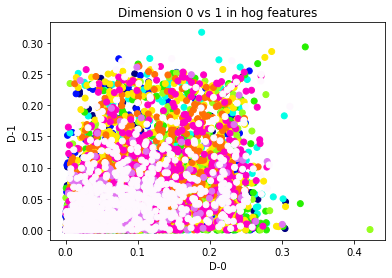

In [25]:
plt.figure()
plt.scatter(train_hog_features[:,0], train_hog_features[:,1], c=trnLabels, cmap='gist_ncar', marker = 'o')#, c=y, 
plt.xlabel("D-0")
plt.ylabel("D-1")
plt.title("Dimension 0 vs 1 in hog features")
plt.show()


In [26]:
#First method K-means
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_hog_features)

test_pred = kmeans.predict(test_hog_features)

accuracy = np.sum(np.equal(tstLabels, test_pred)) / tstLabels.shape[0] * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 15.50%


In [27]:
#Second method Gaussian Mixture Models
gmm = GaussianMixture(n_components=10)
gmm.fit(train_hog_features)

train_pred = gmm.predict(train_hog_features)
test_pred = gmm.predict(test_hog_features)

accuracy = np.sum(np.equal(tstLabels, test_pred)) / tstLabels.shape[0] * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 7.80%


In [29]:
#Third method Linear Regression
regr = LinearRegression()
regr.fit(train_hog_features, trnLabels)

test_pred = regr.predict(test_hog_features).round(0)

accuracy = np.sum(np.equal(tstLabels, test_pred)) / tstLabels.shape[0] * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 12.90%


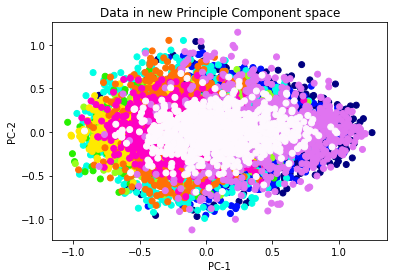

Percentage accuracy on testing set is: 51.40%


In [30]:
#Fourth method Principal Component Analysis
pca = PCA(n_components=2)
pca.fit(train_hog_features)
projected_data = pca.transform(train_hog_features)

plt.figure()
plt.scatter(projected_data[:,0], projected_data[:,1], c=trnLabels, cmap='gist_ncar', marker = 'o')#, c=y, 
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.title("Data in new Principle Component space")
plt.show()

C = 1
svc = SVC(kernel='linear', C=C)
svc.fit(train_hog_features, trnLabels)
y_pred = svc.predict(test_hog_features)

accuracy = np.sum(np.equal(tstLabels, y_pred)) / tstLabels.shape[0] * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

LDA:   Percentage accuracy on testing set is: 49.40%
(9,)


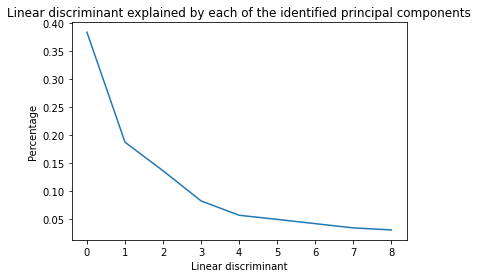

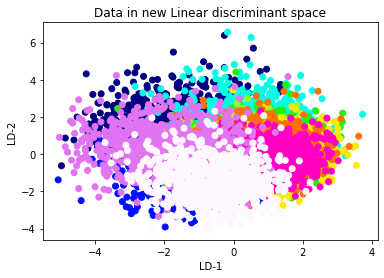

In [31]:
#Fifth method Linear Discriminative Analysis
components = 9
lda = LinearDiscriminantAnalysis(n_components=components)
lda.fit(train_hog_features, trnLabels)
lda_train_projected_data = lda.transform(train_hog_features)
lda_test_projected_data = lda.transform(test_hog_features)

test_pred = lda.predict(test_hog_features)

accuracy = np.sum(np.equal(tstLabels, test_pred)) / tstLabels.shape[0] * 100
print('LDA:   Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

print(lda.explained_variance_ratio_.shape)

plt.figure()
plt.plot(lda.explained_variance_ratio_)
plt.xticks(range(0, components))
plt.xlabel('Linear discriminant')
plt.ylabel('Percentage')
plt.title('Linear discriminant explained by each of the identified principal components')
plt.show(block=False)

plt.figure()
plt.scatter(lda_train_projected_data[:,0], lda_train_projected_data[:,1], c=trnLabels, cmap='gist_ncar', marker = 'o')
plt.xlabel("LD-1")
plt.ylabel("LD-2")
plt.title("Data in new Linear discriminant space")
plt.show()

In [34]:
#Sixth method Neural Networks
def neural_net():
    start = time.time()
    BATCH_SIZE = 238
    # Getting the data
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    # Normalising the data
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    
    number_of_classes = np.max(train_labels) + 1
    
    model = keras.Sequential()
    BIAS = 0.1
    
    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1],)))

    # Create hidden layers
    model.add(keras.layers.Dense(22, activation='elu',use_bias=BIAS)) # first layer
    model.add(keras.layers.Dense(22, activation='elu',use_bias=BIAS)) # second layer

    # Create output layer to get predicted class labels.
    model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # fit model
    history = model.fit(train_data, train_labels,batch_size=BATCH_SIZE, 
                        validation_data=(test_data, test_labels), epochs=700, verbose=1, use_multiprocessing=True)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = model.predict(test_data)

    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    end = time.time()
    
    print("Accuracy: "+str(accuracy_score(test_labels, predicted_labels)*100)+"%")
    print('\n')
    target_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    confusion_matrix_generator(test_labels,predicted_labels)
    return ((end-start)/60)

Epoch 1/700
43/43 [==============================] - 0s 9ms/step - loss: 2.4012 - acc: 0.1373 - val_loss: 2.2458 - val_acc: 0.1760
Epoch 2/700
43/43 [==============================] - 0s 2ms/step - loss: 2.1778 - acc: 0.1969 - val_loss: 2.0896 - val_acc: 0.2210
Epoch 3/700
43/43 [==============================] - 0s 2ms/step - loss: 2.0524 - acc: 0.2435 - val_loss: 1.9827 - val_acc: 0.2740
Epoch 4/700
43/43 [==============================] - 0s 2ms/step - loss: 1.9601 - acc: 0.2810 - val_loss: 1.9033 - val_acc: 0.3120
Epoch 5/700
43/43 [==============================] - 0s 2ms/step - loss: 1.8890 - acc: 0.3160 - val_loss: 1.8450 - val_acc: 0.3400
Epoch 6/700
43/43 [==============================] - 0s 1ms/step - loss: 1.8322 - acc: 0.3413 - val_loss: 1.7956 - val_acc: 0.3660
Epoch 7/700
43/43 [==============================] - 0s 2ms/step - loss: 1.7840 - acc: 0.3625 - val_loss: 1.7546 - val_acc: 0.3870
Epoch 8/700
43/43 [==============================] - 0s 2ms/step - loss: 1.7437 - a

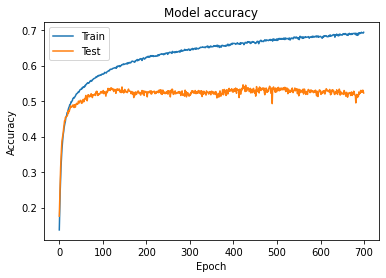

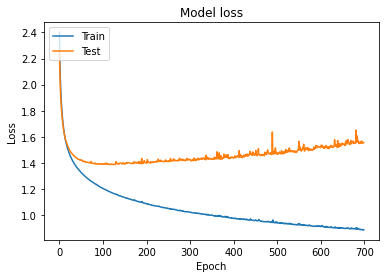

[[61  2  9  2  3  2  3  4 11  3]
 [ 4 58  3  4  3  1  3  2 14  8]
 [11  4 43  6  8 13  7  5  1  2]
 [ 1  4 16 30  8 20 10  6  3  2]
 [ 4  1 13  8 49  6  9  4  3  3]
 [ 2  1 12 11  6 48 10  9  1  0]
 [ 4  2  9  9 10  3 58  1  2  2]
 [ 2  1  4  5 13 11  2 55  0  7]
 [12 10  4  1  2  0  3  0 57 11]
 [ 4  8  3  3  5  0  0  4  9 64]]


<ipython-input-27-76498e29843a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-76498e29843a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


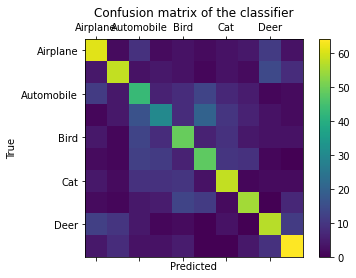

1.662670107682546


In [65]:
the_time = neural_net()
print(the_time)

In [39]:
#Seventh method Support Vector Machine
def svm():
    # Getting the data
    train_data, train_labels, test_data, test_labels = get_data()
    train_data,train_labels = shuffle(train_data,train_labels)
    test_data,test_labels = shuffle(test_data,test_labels)
    
    # Getting the features
    hog_features,test_features,hog_images,test_images = get_features(train_data,train_labels,
                                                                     test_data,test_labels)
    print(np.shape(hog_features))
    
    # Reshape the labels
    train_labels =  np.array(train_labels).reshape(len(train_labels),1).ravel()
    test_labels = np.array(test_labels).reshape(len(test_labels),1).ravel()
    
    # Normalising the data
    normaliser = StandardScaler().fit(hog_features)
    train_data = normaliser.transform(hog_features)
    test_data = normaliser.transform(test_features)
    #train_data,test_data = reduce_dimensions(train_data,test_data)
    
    C = 1 # Reg value, higher value smaler margin of hyperplane (Avoid missclassifiying each training example)
    model = SVC(kernel='linear', C=C,verbose=True)
    model.fit(train_data, train_labels)
    
    # Testing
    predicted_labels = model.predict(test_data)
    
    print("Accuracy: "+str(accuracy_score(test_labels, predicted_labels)*100)+"%")
    print('\n')
    target_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    print(classification_report(test_labels, predicted_labels, target_names=target_names))
    confusion_matrix_generator(test_labels,predicted_labels)

(10000, 324)
[LibSVM]Accuracy: 48.5%


              precision    recall  f1-score   support

    Airplane       0.54      0.61      0.58       100
  Automobile       0.56      0.54      0.55       100
        Bird       0.37      0.43      0.40       100
         Cat       0.32      0.30      0.31       100
        Deer       0.42      0.47      0.44       100
         Dog       0.41      0.40      0.40       100
        Frog       0.48      0.49      0.49       100
       Horse       0.57      0.48      0.52       100
        Ship       0.56      0.55      0.55       100
       Truck       0.67      0.58      0.62       100

    accuracy                           0.48      1000
   macro avg       0.49      0.48      0.49      1000
weighted avg       0.49      0.48      0.49      1000

[[61  3  7  2  4  0  2  5 13  3]
 [ 4 54  2  5  4  2  7  2 10 10]
 [10  3 43  6  8 16  6  5  3  0]
 [ 5  4 12 30 14 15 11  5  2  2]
 [ 3  2 16  8 47  7 10  1  3  3]
 [ 1  2 16 15  7 40 10  8  0  1]
 [ 4

<ipython-input-23-76498e29843a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-23-76498e29843a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


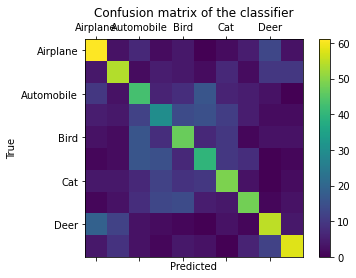

In [40]:
svm()